# WGAN - PyTorch

In this notebook we will be looking at another type of GANs' called Wasserstein GANs'. WGANs' have been proven to be quite effective. This implementation is almost similar to the original implementation by the authors of the WGAN papers.

Reference : https://arxiv.org/abs/1701.07875

Reference : https://github.com/martinarjovsky/WassersteinGAN

In this implementation we will be particularly working with the LSUN dataset of bedroom images.

Reference : http://lsun.cs.princeton.edu/2017/

**NOTE**

This notebook builds open some PyTorch concepts which were introduced in the 'PyTorch - Simple Classification Network.ipynb' notebook. If some PyTorch concepts seem unclear, please try and search for that in the above mentioned notebook.


## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

%matplotlib inline

In [2]:
PATH = 'data/lsun'
BATCH_SIZE = 1024
IMAGE_SIZE = 64
NOISE_DIM = 100

In [3]:
transformations = transforms.Compose( [  transforms.Scale(IMAGE_SIZE),
                                         transforms.CenterCrop(IMAGE_SIZE),
                                         transforms.ToTensor(),
                                         transforms.Normalize( mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)   )
                                      ])

/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [4]:
data = torchvision.datasets.LSUN(db_path=PATH, classes=['bedroom_train'],transform=transformations)

dataLoader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)

In [5]:
n = len(dataLoader)
n

2962

In [6]:
dataiter = iter(dataLoader)
img, _ = dataiter.next()

Process Process-8:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-1:
  File "/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-3:
Traceback (most recent call last):
Process Process-2:
Process Process-6:
  File "/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-4:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/site-packa

In [7]:
def show(img):
    plt.figure(figsize=(15,15))
    
    img = img*0.5 + 0.5 #unnormalize the data first
    
    #Since we will be using tanh as our activation, we are clipping the floats to be in range [-1,1]
    img = img.clamp(-1,1)
    
    # To convert a torch tensor to a numpy array, we just call .numpy on the tensor
    
    img = img.numpy()
    
    # Now the image is format (#channels, height, width)
    # For tensorflow, the channel should appear at the last
    
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.plot()

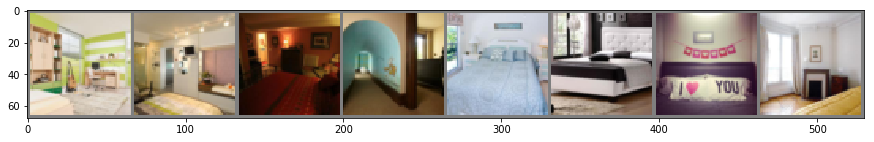

In [8]:
show(torchvision.utils.make_grid(img[:8]))

## Create Models

### Create Discriminator

In [9]:
class Discriminator(nn.Module):
    
    # Each conv block will basically containg one Conv layer followed by a BatchNorm layer which is in turn
    # followed by a LeakyRelu layer
    
    def conv_block(self, main, name, in_channels, out_channels, kernel_size, stride, padding):
        
        conv_name = str(name) + '-' + str(in_channels) + '-' + str(out_channels) + '.conv'
        batch_name = str(name) + '-' + str(out_channels) + '.batch'
        relu_name = str(name) + '-' + str(out_channels) + '.relu'
        
        main.add_module(conv_name, nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) )
        main.add_module(batch_name, nn.BatchNorm2d(out_channels))
        main.add_module(relu_name, nn.LeakyReLU(0.2, inplace=True))
        
    def __init__(self, image_size, n_input_image_channels, n_filters, n_gpu, n_extra_blocks = 0):
        
        super(Discriminator,self).__init__()
        self.n_gpu = n_gpu
        
        main = nn.Sequential()
        
        #Adding the first convolutional block
        self.conv_block(main,'initial',n_input_image_channels, n_filters, 4,2,1)
        
        # We have an option to set a few more conv blocks at the beginning if we want to
        # The number of input channels to these will be the output channels 
        # of our initial conv block , i.e. n_filters
        
        for i in range(n_extra_blocks):
            name = 'extra_'+str(i+1)
            self.conv_block(main, name,n_filters,n_filters,3,1,1)
        
        # The number of output channels of above extra conv blocks will be n_filters
        conv_size = image_size / 2
        conv_filters = n_filters
        
        # In the blocks below we are using a stride of 2, thus we are effectively reducing image size by half
        # To compensate for this we are doubling the number of channels
        
        while conv_size > 4:
            self.conv_block(main, 'pyramid', conv_filters, conv_filters*2, 4,2,1)
            conv_size = conv_size / 2
            conv_filters = conv_filters * 2
        
        # Now we are done with this, we need to add the final conv layer
        
        # The number of output channels of the previous pyramidal conv block would be conv_filters which is input
        # to this final layer.
        
        # The output channels of this final layer will just be 1 since the Discriminator just needs to output 0 
        # or 1
        
        final_name = 'final-'+str(conv_filters)+'-1.conv'
        main.add_module(final_name, nn.Conv2d(conv_filters,1,4,1,0))
        
        self.main = main
    
    def forward(self, x):
        
        gpu_ids = None
        
        # Now, PyTorch also supports multi-gpu parallelism. We will be implementing our forward pass
        # to take advatange of that in case anyone has more than 1 GPU
        
        # Reference : http://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
        
        if isinstance(x.data, torch.cuda.FloatTensor) and self.n_gpu > 1:
            gpu_ids = range(self.n_gpu)
        
        # data_parralel : Evaluates module(input) in parallel across the GPUs given in device_ids
        output = nn.parallel.data_parallel(self.main, x, gpu_ids)
        
        output = output.mean(0)
        output = output.view(1)
        
        return output

### Create Generator

In [10]:
class Generator(nn.Module):
    
    # Each deconv block will basically containg one Conv2dTranspose layer followed by a BatchNorm layer 
    # which is in turn followed by a ReLu layer. (Note the final layer here is ReLu and not LeakyReLu)
    
    def deconv_block(self, main, name, in_channels, out_channels, kernel_size, stride, padding):
        
        de_conv_name = str(name) + '-' + str(in_channels) + '-' + str(out_channels) + '.convt'
        batch_name = str(name) + '-' + str(out_channels) + '.batch'
        relu_name = str(name) + '-' + str(out_channels) + '.relu'
        
        main.add_module(de_conv_name, \
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        main.add_module(batch_name, nn.BatchNorm2d(out_channels))
        main.add_module(relu_name, nn.ReLU(inplace=True))
    
    def __init__(self, image_size, n_noise_dim, n_input_image_channels, n_filters, n_gpu, n_extra_blocks = 0):
        
        super(Generator,self).__init__()
        
        self.n_gpu = n_gpu
        
        # These few lines are just a way to determine the number of output channels for the first deconv block
        # We might as well have just used a random number
        
        deconv_filters = n_filters //2
        temp = 4
        
        while temp!= image_size:
            deconv_filters = deconv_filters *2
            temp = temp*2
        
        main = nn.Sequential()
        
        # Now the input to the Generator is just a random noise vector
        self.deconv_block(main, 'initial', n_noise_dim, deconv_filters, 4,1,0)
        
        deconv_size = 4
        
        # Now are are using a stride of 2 in all the transposed convolutions blocks, this means the size of the 
        # image is doubling in every block. So we are halving the number of filters after each block.
        
        while deconv_size < image_size //2 :
            self.deconv_block(main,'pyramid', deconv_filters, deconv_filters//2,4,2,1)
            deconv_size = deconv_size*2
            deconv_filters = deconv_filters //2
        
        # Extra deconv blocks
        
        # NOTE : I dont know why we are adding extra layers after the pyramid here. We might try adding these 
        # before the pyramid later.
        
        for i in range(n_extra_blocks):
            name = 'extra_' + str(i+1)
            self.deconv_block(main, name, deconv_filters,deconv_filters, 3,1,1)
        
        # Now for the final layer
        # The number of input channels will be the output of previous layers, i.e. deconv_filters
        # The number of output channels will be n_input_image_channels since the output of the generator 
        # needs to be fed into the Discriminator.
        
        final_name = 'final_' + str(deconv_filters)+'_'+str(n_input_image_channels) + '.convt'
        main.add_module(final_name, \
                        nn.ConvTranspose2d(deconv_filters, n_input_image_channels, 4,2,1, bias=False))
        
        tanh_name = 'tanh_'+str(n_input_image_channels)
        main.add_module(tanh_name, nn.Tanh())
        
        self.main = main
        
    def forward(self, x):
        
        gpu_ids = None
        
        if isinstance(x.data, torch.cuda.FloatTensor) and self.n_gpu > 1:
            gpu_ids = range(gpu_ids)
        
        output = nn.parallel.data_parallel(self.main, x, gpu_ids)
        return output

### Create WGAN

In [11]:
def initialize_weights(m):
    
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.00, 0.02)
    
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

In [12]:
discriminator = Discriminator(IMAGE_SIZE, 3, 64, 1, 1).cuda()
discriminator.apply(initialize_weights)

Discriminator(
  (main): Sequential(
    (initial-3-64.conv): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial-64.batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (initial-64.relu): LeakyReLU(0.2, inplace)
    (extra_1-64-64.conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (extra_1-64.batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (extra_1-64.relu): LeakyReLU(0.2, inplace)
    (pyramid-64-128.conv): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): LeakyReLU(0.2, inplace)
    (pyramid-128-256.conv): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batch): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): LeakyReLU(0.2, inplace)
    (pyramid-256-512.conv): Conv2

In [13]:
params = list(discriminator.parameters())
print("Number of parameters are : " + str(len(params)))

for param in params:
    print(param.size())

Number of parameters are : 17
torch.Size([64, 3, 4, 4])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 4, 4])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 4, 4])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 4, 4])
torch.Size([512])
torch.Size([512])
torch.Size([1, 512, 4, 4])
torch.Size([1])


In [14]:
generator = Generator(IMAGE_SIZE, NOISE_DIM, 3, 64, 1, 1).cuda()
generator.apply(initialize_weights)

Generator(
  (main): Sequential(
    (initial-100-512.convt): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batch): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU(inplace)
    (pyramid-512-256.convt): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batch): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU(inplace)
    (pyramid-256-128.convt): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU(inplace)
    (pyramid-128-64.convt): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU(inplace)
    (extra_1-64-64.convt): ConvTranspose

In [15]:
params = list(generator.parameters())
print("Number of parameters are : " + str(len(params)))

for param in params:
    print(param.size())

Number of parameters are : 16
torch.Size([100, 512, 4, 4])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 4, 4])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 4, 4])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 4, 4])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 3, 4, 4])


In [16]:
def Var(*params):
    return Variable(torch.FloatTensor(*params).cuda())

In [17]:
def create_noise(batch_size):
    return Variable(torch.FloatTensor(batch_size,NOISE_DIM, 1, 1).cuda().normal_(0,1))

In [18]:
input = Var(BATCH_SIZE, 3, IMAGE_SIZE, NOISE_DIM)

In [19]:
input.shape

torch.Size([1024, 3, 64, 100])

In [20]:
fixed_noise = create_noise(BATCH_SIZE)

In [21]:
fixed_noise.shape

torch.Size([1024, 100, 1, 1])

Lets create labels for real images

In [22]:
ones = torch.FloatTensor([1]).cuda()

Lets create labels for fake images

In [23]:
minus_ones = ones * -1

In [26]:
optimizerD = optim.RMSprop(discriminator.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(generator.parameters(), lr = 1e-4)

In [27]:
def one_forward_and_backward_step_of_discriminator(inp, init_grad) :
    error = discriminator(inp)
    error.backward(init_grad)
    return error

In [28]:
def make_trainable(model, v):
    for param in model.parameters():
        param.requires_grad = v

In [32]:
def train(n_epochs):
    generator_iterations = 0
    for epoch in range(n_epochs):
        
        if(epoch%10 == 0):
            print("Epoch : " + str(epoch+1))
        
        dataiter = iter(dataLoader)
        
        i=0
        while i < n:
            if i%10 == 0:
                print("Examples Done : " + str(i+1))
            make_trainable(discriminator, True)
            
            if generator_iterations < 25 or generator_iterations % 500 == 0:
                discriminator_iterations = 100
            else:
                discriminator_iterations = 5
            
            j = 0
            
            ############################################################################################
            # TRAIN DISCRIMINATOR
            ############################################################################################
            while j < discriminator_iterations and i < n:
                #print("J : " + str(j))
                discriminator.zero_grad()
                
                j = j + 1; i = i + 1
                
                # clamp discriminator weights
                
                for param in discriminator.parameters():
                    param.data.clamp_(-0.01,0.01)
                
                # train Discriminator on real images 
                real_images, _ = dataiter.next()
                real_images = Variable(real_images.cuda())
        
                error_real = one_forward_and_backward_step_of_discriminator(real_images,ones)
                
                # train Discriminator on Fake Images
                
                fake_images = generator(create_noise(BATCH_SIZE))
                input.data.resize_(real_images.size()).copy_(fake_images.data)
                
                error_fake = one_forward_and_backward_step_of_discriminator(fake_images, minus_ones)
                
                # Now that we have accumulated gradients, we can do an optimization step to update the weights
                optimizerD.step()
            
            ############################################################################################
            # TRAIN GENERATOR
            ############################################################################################
            
            # While training generator, we dont want to update the weights of the discriminator
            
            make_trainable(discriminator,False)
            
            generator.zero_grad()
            fake_images = generator(create_noise(BATCH_SIZE))
            
            # Now the generator has to learn images in such a way that the discriminator thinks them of as real
            error_G = one_forward_and_backward_step_of_discriminator(fake_images, ones)
            optimizerG.step()
            generator_iterations = generator_iterations + 1
            
            
            print('[%d/%d][%d/%d][%d]' % (epoch, n_epochs, i, n, generator_iterations))

In [33]:
%time train(1)

Epoch : 1
Examples Done : 1
[0/1][100/2962][1]
Examples Done : 101
[0/1][200/2962][2]
Examples Done : 201
[0/1][300/2962][3]
Examples Done : 301
[0/1][400/2962][4]
Examples Done : 401
[0/1][500/2962][5]
Examples Done : 501
[0/1][600/2962][6]
Examples Done : 601
[0/1][700/2962][7]
Examples Done : 701
[0/1][800/2962][8]
Examples Done : 801
[0/1][900/2962][9]
Examples Done : 901
[0/1][1000/2962][10]
Examples Done : 1001
[0/1][1100/2962][11]
Examples Done : 1101
[0/1][1300/2962][13]
Examples Done : 1301
[0/1][1400/2962][14]
Examples Done : 1401
[0/1][1500/2962][15]
Examples Done : 1501
[0/1][1600/2962][16]
Examples Done : 1601
[0/1][1700/2962][17]
Examples Done : 1701
[0/1][1800/2962][18]
Examples Done : 1801
[0/1][1900/2962][19]
Examples Done : 1901
[0/1][2000/2962][20]
Examples Done : 2001
[0/1][2100/2962][21]
Examples Done : 2101
[0/1][2200/2962][22]
Examples Done : 2201
[0/1][2300/2962][23]
Examples Done : 2301
[0/1][2400/2962][24]
Examples Done : 2401
[0/1][2500/2962][25]
Examples Don

RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1512382878663/work/torch/lib/THC/THCTensorCopy.cu:31

In [34]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [35]:
a = 10
a

10

In [36]:
fake = generator(fixed_noise).data.cpu()

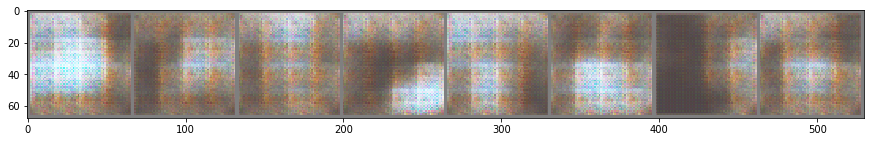

In [38]:
show(torchvision.utils.make_grid(fake[:8]))